# Linear Regression

In this example we will fit a model to a linear data by performing gradient descent on a loss function
using PyTorch. The dataset is is comprises of metabolic rates and masses for various animals. Kleiber's Law
states that the log of the metabolic rate vs mass is linear. We will demonstrate this.

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from matplotlib import pyplot as plt; plt.style.use('ggplot')

**Load the dataset**

Although we don't need to use a PyTorch Dataset and DataLoader for a simple example like this,
we use it anyway for completeness and for our own practice.

In [17]:
class KleibersLawDataset(Dataset):
    def __init__(self, path):
        data = np.loadtxt(path,delimiter=",")
        self.inputs = torch.log(torch.from_numpy(data[0, :])).to(torch.float32)
        self.outputs = torch.log(torch.from_numpy(data[1, :])).to(torch.float32)

    def __len__(self):
        return (len(self.inputs))

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

    def scatter_plot(self):
        x = self.inputs.numpy()
        y = self.outputs.numpy()
        plt.figure(figsize=(5,3))
        plt.scatter(x,y)
        plt.show()

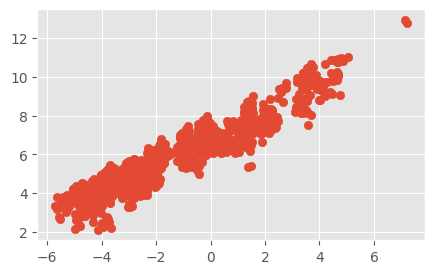

In [18]:
# load the dataset
training_data = KleibersLawDataset("./datasets/kleibers_law_data.csv")

# Show a plot of the raw data
training_data.scatter_plot()

# Create a DataLoader
dataloader = DataLoader(training_data)

**Define a model**

Here we define a linear model using the `torch.nn.Module` and define a single linear layer with 
`torch.nn.Linear` and specifying that there is 1 input for 1 output. Although this is setup as a neural
network, a forward pass simply applies a linear transformation to x and that's it - 
i.e. it just computes $f(x) = mx+b$

In [19]:
# Define a linear model with torch.nn.Module
class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

**Setup**

Here we instantiate the linear model, the loss function, and the optimizer. For the loss function we choose
to use the mean square error loss and for the optimizer we use stochastic gradient descent.

In [23]:
# instatiate the model based on the size of the input data
model = LinearModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

**Training**

Now we train the model. The loss is saved at each epoch and plotted at the end.

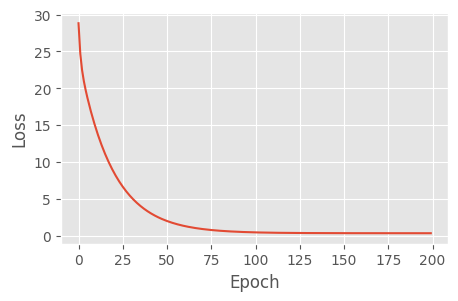

In [24]:

# get the training data from the dataloader
logx = dataloader.dataset.inputs
logy = dataloader.dataset.outputs

num_epochs = 200
loss_hist = []

for epoch in range(num_epochs):

    # Forward pass to get a prediction
    outputs = model(logx.view(-1,1))

    # Compute the loss
    loss = criterion(outputs, logy.view(-1,1))
    loss_hist.append(loss.detach().float())

    # Zero the gradients, do a backwards pass, and take a gradient step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(list(range(num_epochs)), loss_hist)
ax.set(xlabel="Epoch",ylabel="Loss")
plt.show()

**Results**

Finally we get the learned slope and intercept and plot the best fit line along with the training data

In [26]:
# Get the weight and bias(slope and y-intercept) of the trained model
m, b = model.linear.weight.item(), model.linear.bias.item()

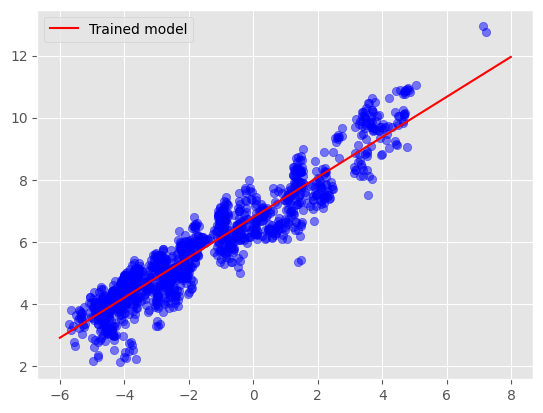

In [31]:
# Plot the trained model along with the raw data
xfit = np.arange(-6,8,0.01)
yfit = m*xfit + b

fig, ax = plt.subplots()
ax.scatter(logx, logy, color="blue", alpha=0.5)
ax.plot(xfit, yfit, color="red", label="Trained model")
ax.set()
ax.legend()
plt.show()